In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.rcParams['axes.grid'] = True

In [48]:
from statsforecast import StatsForecast
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsforecast.models import (
    AutoARIMA,
    AutoETS,
    AutoTheta,
    SeasonalNaive,
    Naive,
    RandomWalkWithDrift,
    HistoricAverage
)
from statsforecast.arima import arima_string

from statsmodels.tsa.seasonal import STL

from statsmodels.tsa.stattools import adfuller, kpss

from utilsforecast.losses import rmse, mae, coverage
from utilsforecast.evaluation import evaluate

from coreforecast.scalers import boxcox
from coreforecast.scalers import boxcox_lambda

from hierarchicalforecast.utils import aggregate
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import BottomUp, MinTrace
from hierarchicalforecast.evaluation import evaluate as hier_evaluate

In [3]:
df = pd.read_csv('./temperature.csv')
df['ds'] = pd.to_datetime(df['ds'], format='%m-%Y')

df["unique_id"] = "temperature"
df = df.rename(columns={"ds": "ds", "Temperature": "y"})
df = df[["unique_id", "ds", "y"]]

df.info()

<class 'pandas.DataFrame'>
RangeIndex: 913 entries, 0 to 912
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  913 non-null    str           
 1   ds         913 non-null    datetime64[us]
 2   y          913 non-null    float64       
dtypes: datetime64[us](1), float64(1), str(1)
memory usage: 31.4 KB


In [4]:
df

,unique_id,ds,y
0,temperature,1950-01-01,22.944054
1,temperature,1950-02-01,24.558395
2,temperature,1950-03-01,27.094870
3,temperature,1950-04-01,28.057873
4,temperature,1950-05-01,27.171478
...,...,...,...
908,temperature,2025-09-01,26.831207
909,temperature,2025-10-01,26.574451
910,temperature,2025-11-01,24.093275
911,temperature,2025-12-01,23.931515


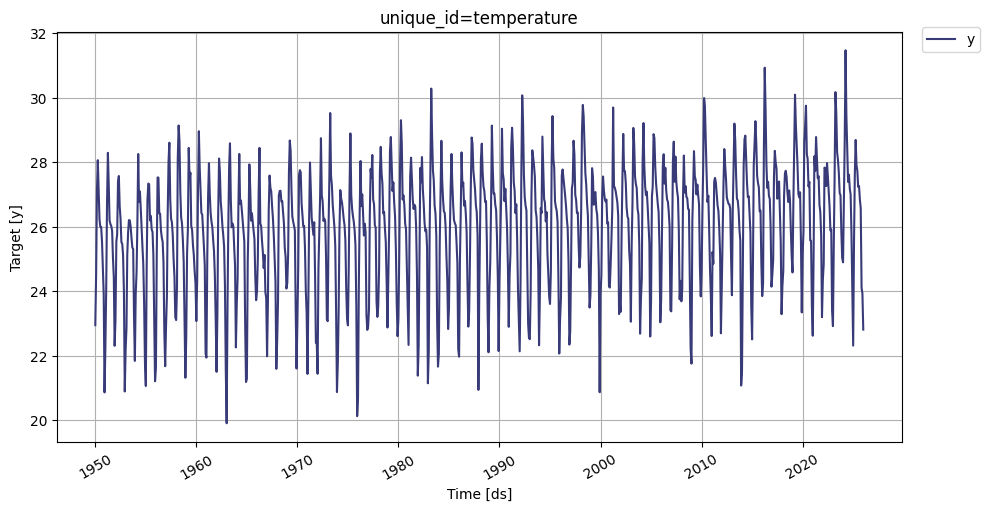

In [5]:
f = StatsForecast.plot(df)
f.set_figwidth(9)
f.set_figheight(5)
f

In [6]:
adf_result = adfuller(df.y)
adf_p_value = adf_result[1]

if adf_p_value < 0.05:
    print(f'Null Hypothesis of non-stationary is rejected -> series is stationary')

Null Hypothesis of non-stationary is rejected -> series is stationary


In [7]:
# The series has a deterministic trend
kpss_result = kpss(df.y)
kpss_p_value = kpss_result[1]

if kpss_p_value < 0.05:
    print(f'Null Hypothesis of Stationary is rejected -> series is non-stationary')

Null Hypothesis of Stationary is rejected -> series is non-stationary


/var/folders/d7/5xjp058538n1_2xf1mtj_bwr0000gn/T/ipykernel_44432/804028792.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(df.y)


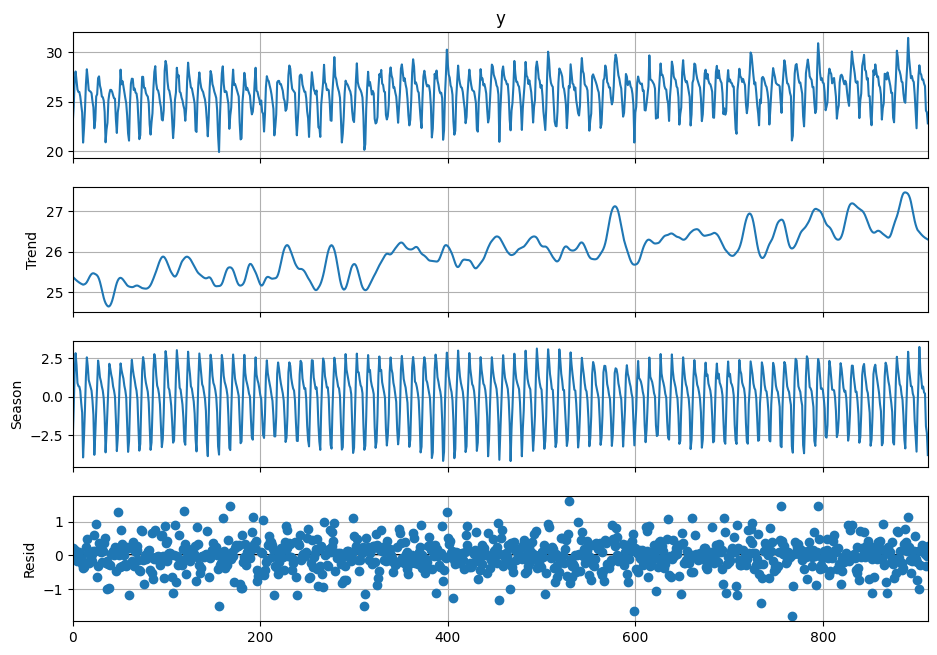

In [8]:
res = STL(df['y'], period=12).fit()

f = res.plot()
f.set_figwidth(10)
f.set_figheight(7)

- The series has a trend and strong seasonal pattern
- SARIMA with seasonal differencing 12

In [9]:
model_arima = AutoARIMA(season_length=12)

sf_arima = StatsForecast(
    models=[model_arima],
    freq='MS'
)

sf_arima.fit(df)

StatsForecast(models=[AutoARIMA])

In [10]:
result_arima = sf_arima.fitted_[0, 0].model_
arima_string(result_arima)

'ARIMA(3,0,1)(2,1,1)[12] with drift        '

### Residual Analysis after fitting ARIMA

In [11]:
residuals_arima = sf_arima.fitted_[0, 0].model_.get("residuals")

res_df_arima = pd.DataFrame({
    'ds': df.ds,
    'residuals': residuals_arima,
    'actual': df.y
})
res_df_arima['fitted'] = res_df_arima.actual - res_df_arima.residuals

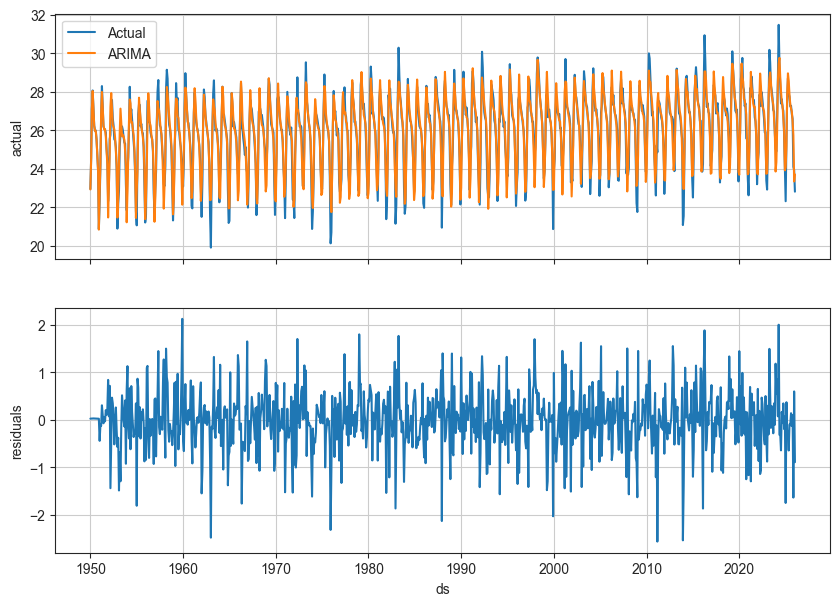

In [12]:
sns.set_style("ticks",{'axes.grid' : True})

fig, axs = plt.subplots(nrows=2, figsize=(10,7), sharex=True)
sns.lineplot(x='ds', y='actual', data=res_df_arima, label='Actual', ax=axs[0])
sns.lineplot(x='ds', y='fitted', data=res_df_arima, label='ARIMA', ax=axs[0])
sns.lineplot(x='ds', y='residuals', data=res_df_arima, ax=axs[1])
plt.show()

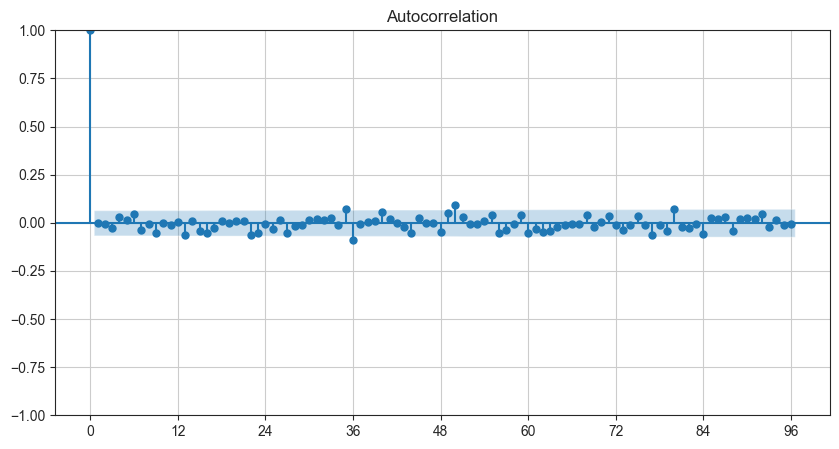

In [13]:
plt.rc("figure", figsize=(10,5))

# skip first 12 months
plot_acf(res_df_arima.residuals[12:], lags=96)
plt.xticks(range(0, 97, 12))
plt.show()

In [14]:
model_ets = AutoETS(season_length=12)

sf_ets = StatsForecast(
    models=[model_ets],
    freq='MS'
)

sf_ets.fit(df)

StatsForecast(models=[AutoETS])

In [15]:
result_ets = sf_ets.fitted_[0, 0].model_
print(result_ets.get("method"))

ETS(A,N,A)


In [16]:
residuals_ets = sf_ets.fitted_[0, 0].model_.get("residuals")

res_df_ets = pd.DataFrame({
    'ds': df.ds,
    'residuals': residuals_ets,
    'actual': df.y
})
res_df_ets['fitted'] = res_df_ets.actual - res_df_ets.residuals

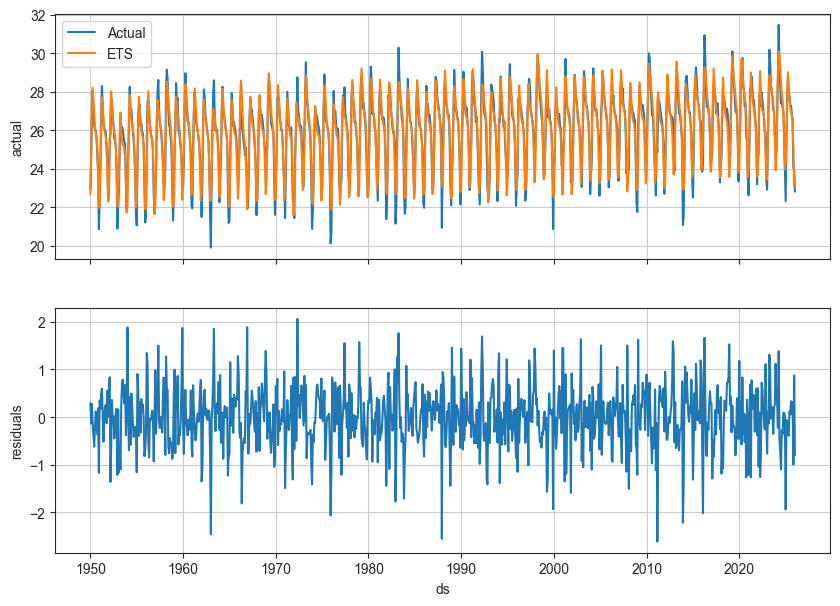

In [17]:
sns.set_style("ticks",{'axes.grid' : True})

fig, axs = plt.subplots(nrows=2, figsize=(10,7), sharex=True)
sns.lineplot(x='ds', y='actual', data=res_df_ets, label='Actual', ax=axs[0])
sns.lineplot(x='ds', y='fitted', data=res_df_ets, label='ETS', ax=axs[0])
sns.lineplot(x='ds', y='residuals', data=res_df_ets, ax=axs[1])
plt.show()

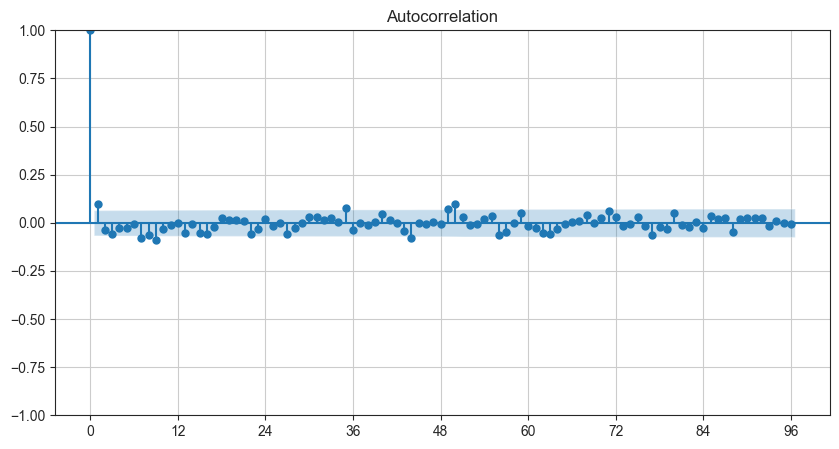

In [18]:
plt.rc("figure", figsize=(10,5))

# skip first 12 months
plot_acf(res_df_ets.residuals[12:], lags=96)
plt.xticks(range(0, 97, 12))
plt.show()

### Baselines and Statistical Models

In [19]:
models = [
    AutoARIMA(season_length=12),
    AutoETS(season_length=12),
    AutoTheta(season_length=12),
    Naive(),
    SeasonalNaive(season_length=12),
    HistoricAverage(),
    RandomWalkWithDrift(),
]

sf_all = StatsForecast(models=models, freq='MS')

In [20]:
cv_df = sf_all.cross_validation(
    df=df,
    h=12,
    n_windows=1,
    step_size=12
)

eval_res = evaluate(
    cv_df,
    metrics=[rmse, mae],
    models=['AutoARIMA', 'AutoETS', 'AutoTheta', 'Naive', 'SeasonalNaive', 'HistoricAverage', 'RWD']
)

eval_res

,unique_id,cutoff,metric,AutoARIMA,AutoETS,AutoTheta,Naive,SeasonalNaive,HistoricAverage,RWD
0,temperature,2025-01-01,rmse,0.636005,0.486804,0.507256,4.407631,1.185926,1.803370,4.411137
1,temperature,2025-01-01,mae,0.428053,0.372261,0.401242,4.039606,0.905732,1.627193,4.044192


In [21]:
eval_res[eval_res['metric'] == 'rmse'].drop(columns=['unique_id','metric','cutoff']).mean().sort_values()

AutoETS            0.486804
AutoTheta          0.507256
AutoARIMA          0.636005
SeasonalNaive      1.185926
HistoricAverage    1.803370
Naive              4.407631
RWD                4.411137
dtype: float64

In [22]:
eval_res[eval_res['metric'] == 'mae'].drop(columns=['unique_id','metric','cutoff']).mean().sort_values()

AutoETS            0.372261
AutoTheta          0.401242
AutoARIMA          0.428053
SeasonalNaive      0.905732
HistoricAverage    1.627193
Naive              4.039606
RWD                4.044192
dtype: float64

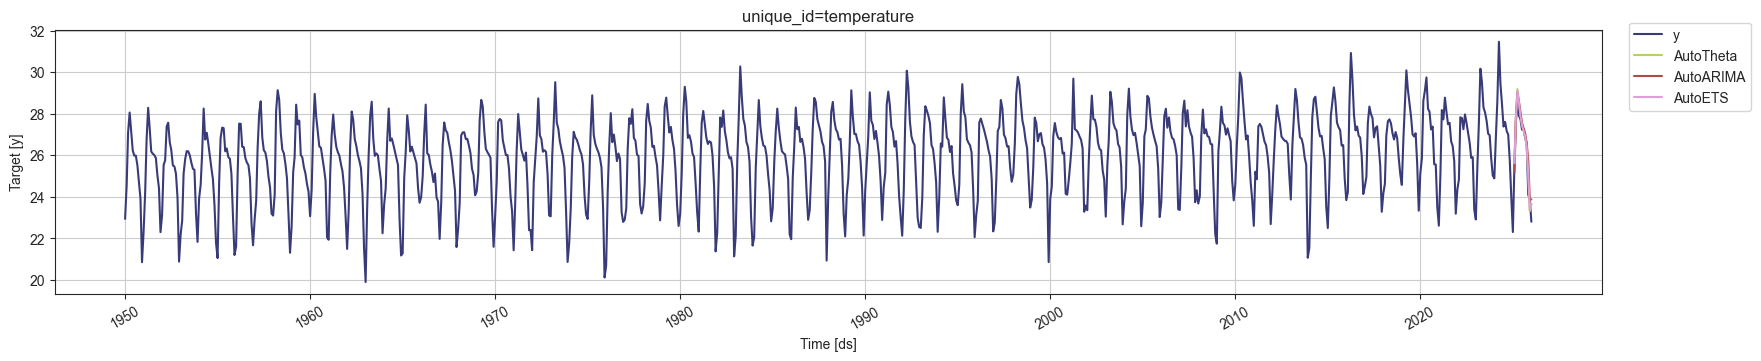

In [23]:
# plot top3 dominating models in cross-validation
StatsForecast.plot(
    df,
    cv_df[
        [
            'unique_id', 'ds', 
            'AutoTheta', 'AutoARIMA', 'AutoETS'
        ]
    ]
)

In [24]:
# with confidence intervals
cv_df_ci = sf_all.cross_validation(
    df=df,
    h=12,
    n_windows=1,
    step_size=12,
    level=[95]
)

eval_res_ci = evaluate(
    cv_df_ci,
    metrics=[coverage],
    models=['AutoARIMA', 'AutoETS', 'AutoTheta', 'Naive', 'SeasonalNaive', 'HistoricAverage', 'RWD'],
    level=[95]
)

eval_res_ci

,unique_id,cutoff,metric,AutoARIMA,AutoETS,AutoTheta,Naive,SeasonalNaive,HistoricAverage,RWD
0,temperature,2025-01-01,coverage_level95,0.916667,1.0,1.0,0.666667,0.916667,1.0,0.666667


### Simple Combination of Univariate Methods

In [25]:
top_models = ['AutoETS', 'AutoTheta']

cv_df['SCUM'] = cv_df[top_models].mean(axis=1)

eval_scum = evaluate(
    cv_df,
    metrics=[rmse, mae],
    models=['AutoARIMA', 'AutoETS', 'AutoTheta', 'SeasonalNaive', 'SCUM']
)

eval_scum

,unique_id,cutoff,metric,AutoARIMA,AutoETS,AutoTheta,SeasonalNaive,SCUM
0,temperature,2025-01-01,rmse,0.636005,0.486804,0.507256,1.185926,0.496480
1,temperature,2025-01-01,mae,0.428053,0.372261,0.401242,0.905732,0.386752


### Transformations

In [26]:
# finding the best lambda
best_lambda = boxcox_lambda(df.y.values, method='guerrero', season_length=12)
print(best_lambda)

-0.8999510633162636


### Prision

In [27]:
df2 = pd.read_csv('./prison.csv')
df2['Date'] = pd.to_datetime(df2['Date'], dayfirst=True)

df2['unique_id'] = df2['State'] + '_' + df2['Gender']

df2 = df2.rename(columns={
    'Date': 'ds',
    'Count': 'y'
})

df2 = df2[['unique_id', 'ds', 'y']]
df2.info()

<class 'pandas.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  768 non-null    str           
 1   ds         768 non-null    datetime64[us]
 2   y          768 non-null    int64         
dtypes: datetime64[us](1), int64(1), str(1)
memory usage: 24.6 KB


In [28]:
df2

,unique_id,ds,y
0,ACT_Female,2005-03-01,7
1,ACT_Male,2005-03-01,171
2,NSW_Female,2005-03-01,650
3,NSW_Male,2005-03-01,8368
4,NT_Female,2005-03-01,25
...,...,...,...
763,TAS_Male,2016-12-01,542
764,VIC_Female,2016-12-01,443
765,VIC_Male,2016-12-01,6333
766,WA_Female,2016-12-01,612


In [29]:
# quarterly data
df2['ds'].diff().value_counts()

ds
0 days     720
92 days     24
91 days     15
90 days      8
Name: count, dtype: int64

In [30]:
df_prison = df2.copy()
df_prison = df_prison.groupby('ds')['y'].sum().reset_index()
df_prison['unique_id'] = 'Australia_Total'
df_prison = df_prison[['unique_id', 'ds', 'y']]

df_prison.head()

,unique_id,ds,y
0,Australia_Total,2005-03-01,24296
1,Australia_Total,2005-06-01,24643
2,Australia_Total,2005-09-01,24511
3,Australia_Total,2005-12-01,24393
4,Australia_Total,2006-03-01,24524


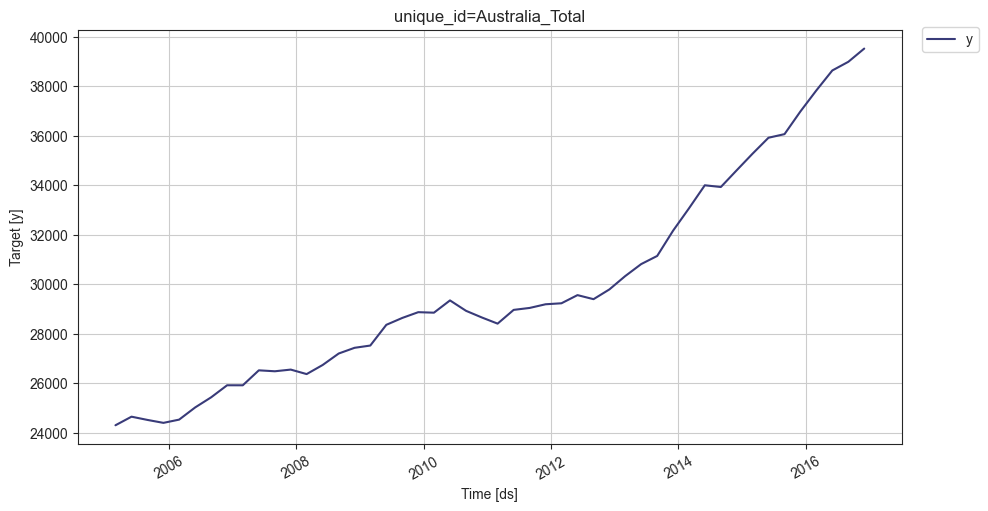

In [31]:
f = StatsForecast.plot(df_prison)
f.set_figwidth(9)
f.set_figheight(5)
f

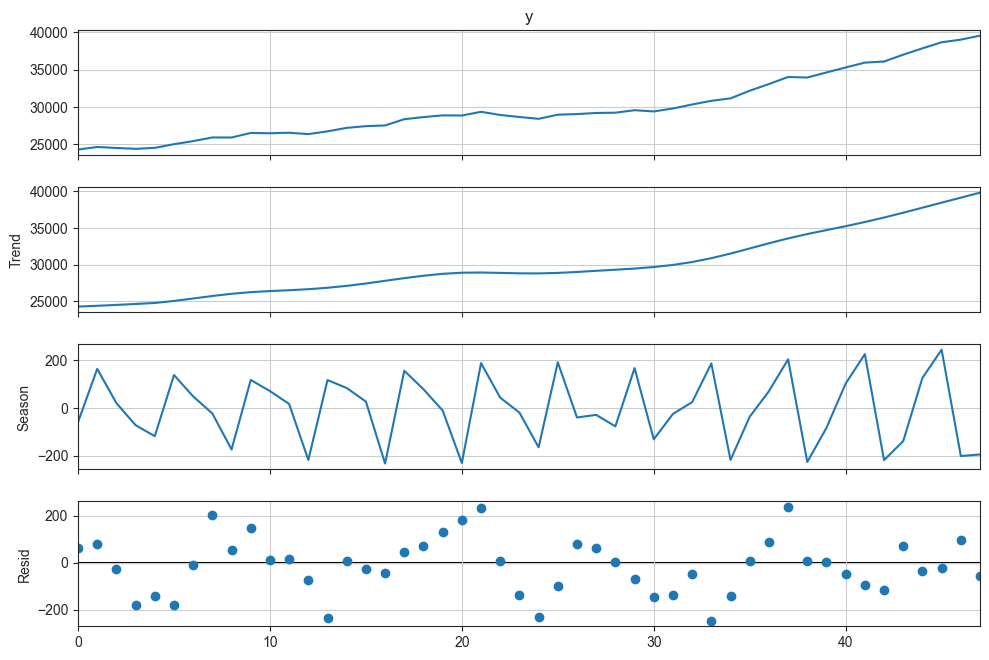

In [32]:
# 4 quarters per season
res = STL(df_prison['y'], period=4).fit()

f = res.plot()
f.set_figwidth(10)
f.set_figheight(7)

- has strong trend but seasonality amplitude is so small.

In [33]:
models = [
    AutoARIMA(season_length=4),
    AutoETS(season_length=4),
    AutoTheta(season_length=4),
    Naive(),
    SeasonalNaive(season_length=4),
    HistoricAverage(),
    RandomWalkWithDrift(),
]

sf_prison = StatsForecast(models=models, freq='QS-MAR')

In [34]:
cv_prison = sf_prison.cross_validation(
    df=df_prison,
    h=4*2,
    n_windows=2,
    step_size=4
)

eval_prison = evaluate(
    cv_prison,
    metrics=[rmse, mae],
    models=['AutoARIMA', 'AutoETS', 'AutoTheta', 'Naive', 'SeasonalNaive', 'HistoricAverage', 'RWD']
)

eval_prison

,unique_id,cutoff,metric,AutoARIMA,AutoETS,AutoTheta,Naive,SeasonalNaive,HistoricAverage,RWD
0,Australia_Total,2013-12-01,rmse,236.949844,2008.112793,2103.765137,3072.342285,4022.103760,7331.125000,1944.577148
1,Australia_Total,2014-12-01,rmse,397.579346,2038.755127,2015.266846,3162.873291,3758.332031,9157.604492,1831.983032
2,Australia_Total,2013-12-01,mae,170.566406,1875.587891,1949.114014,2816.000000,3868.750000,7227.445312,1804.529053
3,Australia_Total,2014-12-01,mae,291.711426,1816.604492,1774.513184,2796.875000,3506.375000,9037.724609,1607.144531


In [35]:
eval_prison[eval_prison['metric'] == 'rmse'].drop(columns=['unique_id','metric','cutoff']).mean().sort_values()

AutoARIMA           317.264587
RWD                1888.280029
AutoETS            2023.433960
AutoTheta          2059.516113
Naive              3117.607910
SeasonalNaive      3890.217773
HistoricAverage    8244.365234
dtype: float32

In [36]:
sf_prison.fit(df_prison)
forecast_prison = sf_prison.predict(h=8)

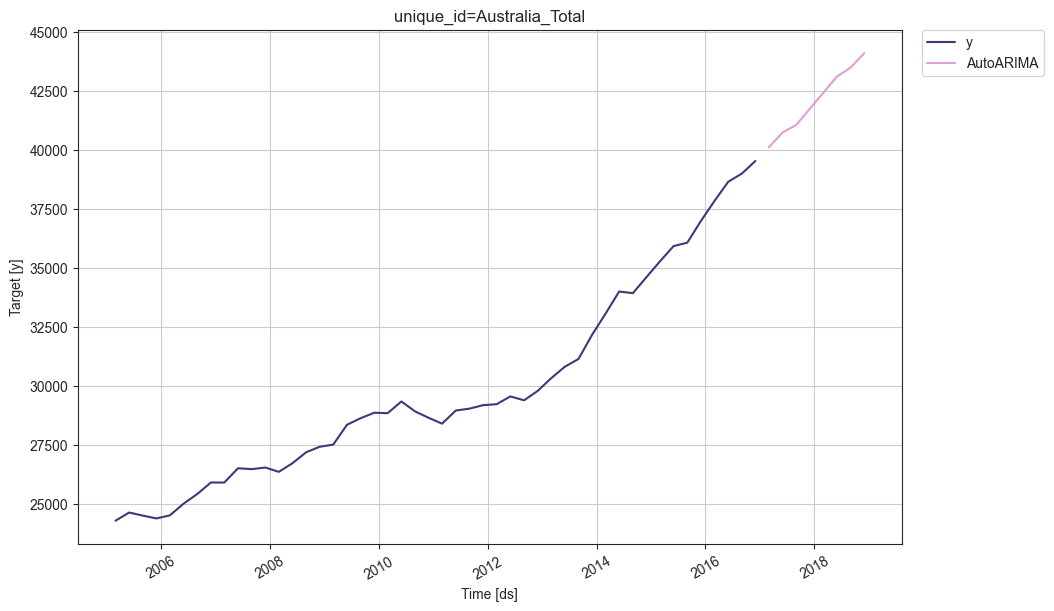

In [37]:
f = sf_prison.plot(df_prison, forecast_prison, models=['AutoARIMA'])
f.set_figwidth(9)
f.set_figheight(6)
f

### Hierarchical Forecasting

In [38]:
df_raw = df2.copy()
df_raw[['State', 'Gender']] = df_raw['unique_id'].str.split('_', expand=True)
df_raw['Country'] = 'Australia'
df_raw = df_raw[['Country', 'State', 'Gender', 'ds', 'y']]

In [39]:
df_raw

,Country,State,Gender,ds,y
0,Australia,ACT,Female,2005-03-01,7
1,Australia,ACT,Male,2005-03-01,171
2,Australia,NSW,Female,2005-03-01,650
3,Australia,NSW,Male,2005-03-01,8368
4,Australia,NT,Female,2005-03-01,25
...,...,...,...,...,...
763,Australia,TAS,Male,2016-12-01,542
764,Australia,VIC,Female,2016-12-01,443
765,Australia,VIC,Male,2016-12-01,6333
766,Australia,WA,Female,2016-12-01,612


In [40]:
# hierarchy spec top to bottom
spec = [
    ['Country'],
    ['Country', 'State'],
    ['Country', 'Gender'],
    ['Country', 'State', 'Gender'],
]

In [41]:
Y_df, S_df, tags = aggregate(df=df_raw, spec=spec)
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

print(tags)
print(Y_df.shape)   # all levels data
print(S_df.shape)   # summing matrix


{'Country': array(['Australia'], dtype=object), 'Country/State': array(['Australia/ACT', 'Australia/NSW', 'Australia/NT', 'Australia/QLD',
       'Australia/SA', 'Australia/TAS', 'Australia/VIC', 'Australia/WA'],
      dtype=object), 'Country/Gender': array(['Australia/Female', 'Australia/Male'], dtype=object), 'Country/State/Gender': array(['Australia/ACT/Female', 'Australia/ACT/Male',
       'Australia/NSW/Female', 'Australia/NSW/Male',
       'Australia/NT/Female', 'Australia/NT/Male', 'Australia/QLD/Female',
       'Australia/QLD/Male', 'Australia/SA/Female', 'Australia/SA/Male',
       'Australia/TAS/Female', 'Australia/TAS/Male',
       'Australia/VIC/Female', 'Australia/VIC/Male',
       'Australia/WA/Female', 'Australia/WA/Male'], dtype=object)}
(1296, 3)
(27, 17)


In [42]:
Y_test_df  = Y_df.groupby('unique_id').tail(8)
Y_train_df = Y_df.drop(Y_test_df.index)

print(f"Train ends:  {Y_train_df['ds'].max()}")
print(f"Test starts: {Y_test_df['ds'].min()}")
print(f"Levels: {list(tags.keys())}")

Train ends:  2014-12-01 00:00:00
Test starts: 2015-03-01 00:00:00
Levels: ['Country', 'Country/State', 'Country/Gender', 'Country/State/Gender']


In [43]:
# train the best model from previous step
sf = StatsForecast(
    models=[AutoARIMA(season_length=4)],
    freq='QS-MAR'
)

sf.fit(Y_train_df)

StatsForecast(models=[AutoARIMA])

In [44]:
Y_hat_df = sf.forecast(
    df=Y_train_df,
    h=8,
    fitted=True
)
Y_fitted_df   = sf.forecast_fitted_values()

In [ ]:
hrec = HierarchicalReconciliation(reconcilers=[
    BottomUp(),
    MinTrace(method='mint_shrink'), # a shrinkage estimator of the covariance matrix
])

Y_rec_df = hrec.reconcile(
    Y_hat_df=Y_hat_df,
    Y_df=Y_fitted_df,   # in-sample fitted values
    S_df=S_df,
    tags=tags
)

Y_rec_df

,unique_id,ds,AutoARIMA,AutoARIMA/BottomUp,AutoARIMA/MinTrace_method-mint_shrink
0,Australia,2015-03-01,35273.296875,35165.308804,35183.411925
1,Australia,2015-06-01,35939.843750,35770.717880,35838.133873
2,Australia,2015-09-01,36049.136719,35853.357288,35922.548880
3,Australia,2015-12-01,36807.160156,36296.090214,36500.181526
4,Australia,2016-03-01,37504.292969,36720.299820,37004.554982
...,...,...,...,...,...
211,Australia/WA/Male,2015-12-01,5053.684570,5053.684570,5107.275302
212,Australia/WA/Male,2016-03-01,5101.174316,5101.174316,5175.568755
213,Australia/WA/Male,2016-06-01,5148.663574,5148.663574,5248.012781
214,Australia/WA/Male,2016-09-01,5196.152832,5196.152832,5285.503924


In [58]:
# merge forecasts with actuals
df_eval = Y_rec_df.merge(Y_test_df, on=['unique_id', 'ds'])

# State level only
eval_state = hier_evaluate(
    df=df_eval,
    tags={'Country/State': tags['Country/State']},
    metrics=[rmse, mae],
)

# state level metrics
print(eval_state)

           level metric   AutoARIMA  AutoARIMA/BottomUp  \
0  Country/State   rmse  374.222363          373.120714   
1  Country/State    mae  338.643665          337.517680   
2        Overall   rmse  374.222363          373.120714   
3        Overall    mae  338.643665          337.517680   

   AutoARIMA/MinTrace_method-mint_shrink  
0                             364.587962  
1                             331.054607  
2                             364.587962  
3                             331.054607  
